**Гипотеза 1**

С помощью t-testа сравним значение оценок пользователей и оценок критиков и проверим гипотезу "Игры выпущенные на консолях получают более высокие средние оценки критиков, чем PC"

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("merged_clean(last_version) (1).csv", sep=';')

consoles = ['PlayStation', 'Xbox', 'Nintendo']

#разделим консоли и PC
#создадим булевы маски для каждой категории
mask_consoles = df['platforms_parsed'].fillna('').apply(lambda x: any(c in x for c in consoles)) | df['platforms_api'].fillna('').apply(lambda x: any(c in x for c in consoles))
df_consoles = df[mask_consoles]
df_pc = df[(df['platforms_parsed'] == 'PC') | (df['platforms_api'] == 'PC')]


#посчитаем средние значения относительно оценки критиков
df_consoles['metascore'].mean()
df_pc['metascore'].mean()

#посчитаем средние значения относительно оценки пользователей
df_consoles[df_consoles['user_score'] != 0]['user_score'].mean()
df_pc[df_pc['user_score'] !=0 ]['user_score'].mean()

def t_test(a, b):
    mean1, mean2 = np.mean(a), np.mean(b)
    var1, var2 = np.var(a, ddof=1), np.var(b, ddof=1)
    n1, n2 = len(a), len(b)
    t_stat = (mean1 - mean2) / np.sqrt(var1/n1 + var2/n2)
    return t_stat

t_metascore = t_test(df_consoles['metascore'].dropna(),df_pc['metascore'].dropna())
t_user = t_test(df_consoles['user_score'].dropna(),df_pc['user_score'].dropna())
#t-статистика для оценок критиков
t_metascore


np.float64(1.0599395644360219)

In [41]:
#t-статистика для оценок пользователей
t_user

np.float64(-0.35640635134043375)

Рассматривая t-статистики относительно оценок критиков |t|<2, значит разница есть, но она настолько маленькая, что может быть просто случайностью в данных. Нельзя сделать четкий вывод.

И относительно оценок пользователей тоже самое, знаит нельзя точно утвеждать что средние оценки Консоли>PC

Построим график по полученным данным относительно оценки критиков

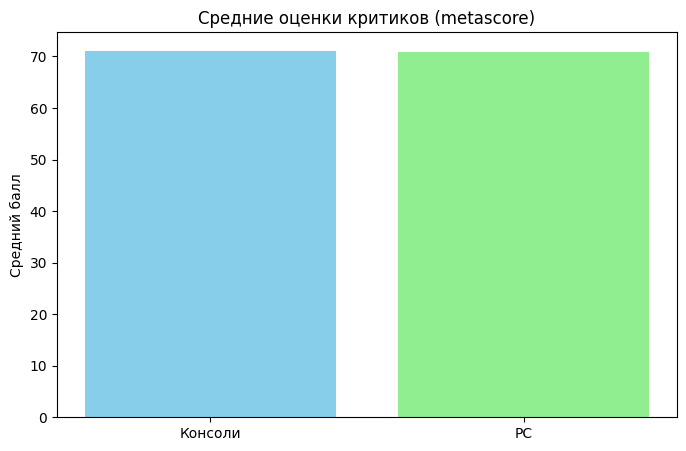

In [42]:
plt.figure(figsize=(8,5))
plt.bar(['Консоли', 'PC'],[df_consoles['metascore'].mean(), df_pc['metascore'].mean()],color=['skyblue', 'lightgreen'])
plt.title("Средние оценки критиков (metascore)")
plt.ylabel("Средний балл")
plt.show()


**Вывод 1:** Относительно оценки критиков гипотеза не подтвердилась. Средние оценик PC немного выше чем у консолей. Статистически разница не сильно значимая

Построим график по полученным данным относительно оценки пользователей

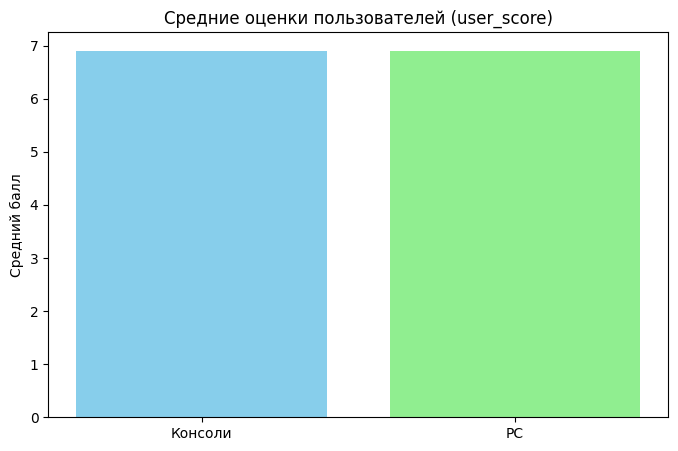

In [43]:
plt.figure(figsize=(8,5))
plt.bar(['Консоли', 'PC'],[df_consoles['user_score'].mean(), df_pc['user_score'].mean()], color=['skyblue', 'lightgreen'])
plt.title("Средние оценки пользователей (user_score)")
plt.ylabel("Средний балл")
plt.show()

**Вывод 2:** Относительно оценок пользователей гипотеза подтвердилась, средние оценки консолей действительно выше чем у PC

**Гипотеза 4**

С помощью нахождения коррелляции между оценками пользователей и оценками критиков проверим гипотезу "Чем выше оценка критиков тем меньше разброс оценок пользователей"

In [44]:
#для подсчета корреляции очистим данные и оставим только строки где оба значения есть и они числовые
df_clean = df[['metascore', 'user_score_amount']].dropna()

In [45]:
correlation = np.corrcoef(df_clean['metascore'], df_clean['user_score_amount'])[0, 1]
correlation

np.float64(0.13761939677567223)

**Вывод:** корреляция слабая пложительная, а для подтверждения гипотезы ожидался  отрицательный знак (рост оценки в следствии падение разброса). Статистически связь слабая и не в нужную сторону. Гипотеза не подтверждается

Построим график для наглядного определения корреляции

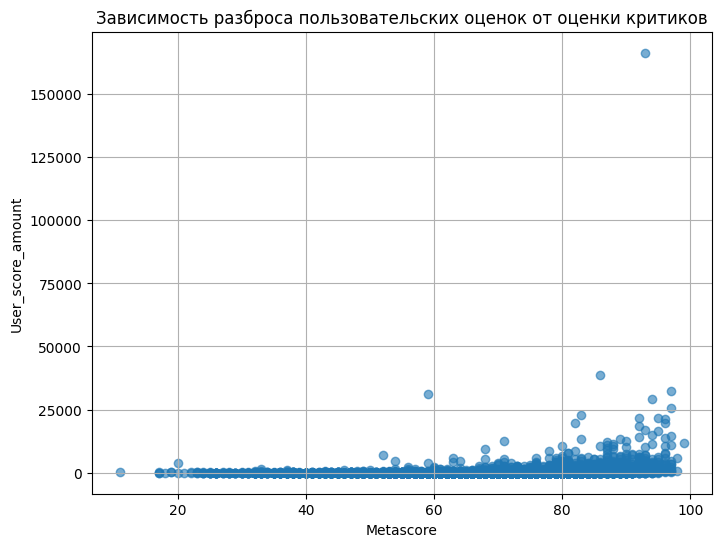

In [46]:
plt.figure(figsize=(8,6))
plt.scatter(df['metascore'], df['user_score_amount'], alpha=0.6)
plt.title("Зависимость разброса пользовательских оценок от оценки критиков")
plt.xlabel("Metascore")
plt.ylabel("User_score_amount")
plt.grid(True)
plt.show()

Это слабая положительная корреляция (значение близко к нулю). Наблюдается тенденция, что с ростом оценки критиков количество пользовательских отзывов слегка увеличивается, но связь очень слабая и незначительная статистически

В целом нельяз рассчитывать на то что хорошие отзывы критиков уменьшат поляризацию отзывов

**Вывод:** Этот график опровергает гипотезу о том, что при росте оценок критиков разброс пользовательских оценок уменьшается.

**Сравнительный анализ**

Сравним средние оценки пользователей между консолями и PC в каждом жанре игр

In [47]:
#Объединяем жанры из двух колонок
df['genres'] = df['genres_parsed'].astype(str)

#Функция для вычисления средней оценки пользователей для конкретного жанра и платформы
def average_user_score_for_genre(df, genre, platforms):
    #Фильтруем данные по жанру
    df_genre = df[df['genres'].str.contains(genre, case=False, na=False)]

    #Фильтруем данные по платформам
    df_platform = df_genre[df_genre['platforms_parsed'].isin(platforms)]

    return df_platform[df_platform['user_score'] !=0 ]['user_score'].mean()

#уникальные жанры
all_genres = pd.Series(df['genres'].str.split(', ').explode().unique())

#словарь для хранения результатов
results = {'genre': all_genres,'console_avg_user_score': all_genres.apply(lambda genre: average_user_score_for_genre(df, genre, consoles)),'pc_avg_user_score': all_genres.apply(lambda genre: average_user_score_for_genre(df, genre, ['PC']))}

results_df = pd.DataFrame(results)

#Убираем строки где обе оценки NaN
results_df = results_df.dropna(subset=['console_avg_user_score', 'pc_avg_user_score'], how='all')


print(f"Обработано жанров: {len(results_df)}")
print(results_df.head())

Обработано жанров: 100
               genre  console_avg_user_score  pc_avg_user_score
0  Open-World Action                  8.4000           6.966667
1        3D Fighting                  7.3375           7.900000
2      3D Platformer                  7.7375           6.714286
3            Skating                  7.9000                NaN
4                FPS                  7.2500           6.868519


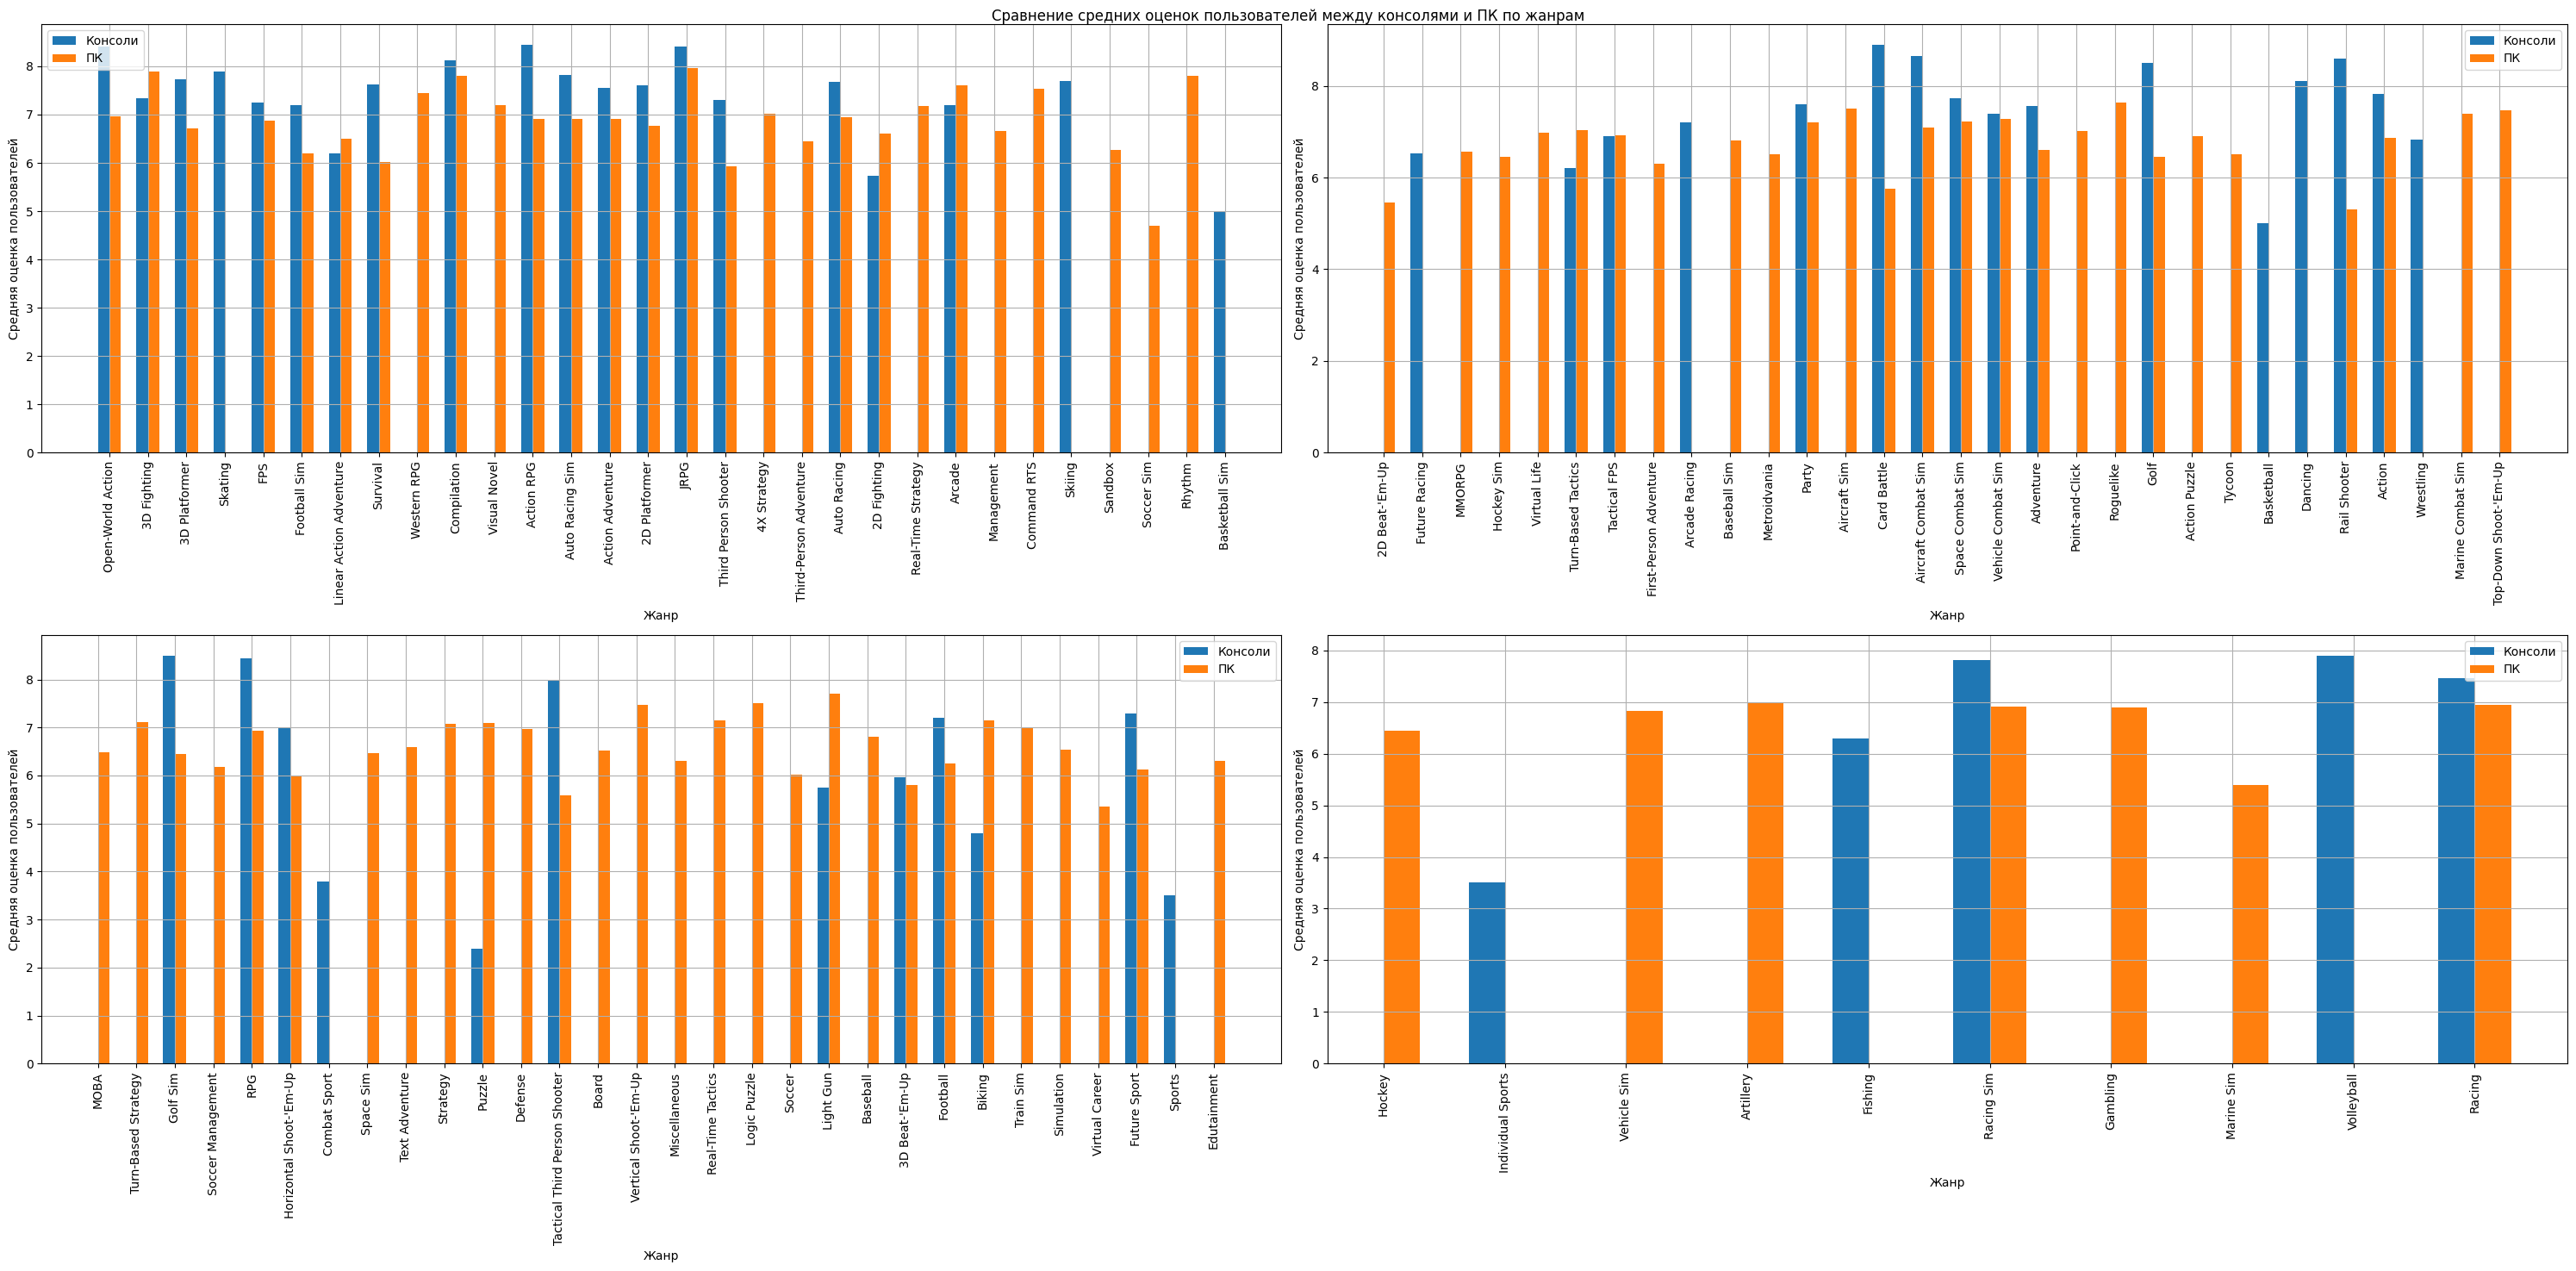

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(30, 15))
#преобразуем таблицу в простой список из 4 графиков
axes = axes.flatten()

#сколько жанров будет в каждой группе
groups = [(0, 30),(30, 60),(60, 90),(90, 100)]
width = 0.3

for i in range(len(groups)):
    start_idx, end_idx = groups[i]
    #данные для текущей группы
    group_df = results_df.iloc[start_idx:end_idx]
    x = np.arange(len(group_df))
    axes[i].bar(x - width/2, group_df['console_avg_user_score'], width, label='Консоли')
    axes[i].bar(x + width/2, group_df['pc_avg_user_score'], width, label='ПК')

    axes[i].set_xlabel('Жанр')
    axes[i].set_ylabel('Средняя оценка пользователей')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(group_df['genre'], rotation=90)
    axes[i].grid(True)
    axes[i].legend()


fig.suptitle('Сравнение средних оценок пользователей между консолями и ПК по жанрам')
plt.tight_layout()
plt.show()

Оценки у технически сложных и требующих точного вводы жанров(игры тактики, стратегии, managment) заметно выше на ПК. А на консолях значительно выше оценки у кинематогрофичных жанров и игр ориентированных на экшн (приключение, гонки).

На консолях более узкий разброс оценок (около 7-8), у PC наоборот

У спортивные поджанров на консолях более низкие оценки